# Notebook 06 – Predictive Model Training

## Step 1: Model Selection

To build a predictive model for classifying engagement in TED Talks, we evaluate three algorithm types:

| Model Type           | Justification                                                 |
|----------------------|---------------------------------------------------------------|
| **Random Forest**    | Non-linear, interpretable, performs well on tabular data      |
| **Logistic Regression** | Linear baseline model, easy to interpret and quick to train |
| **XGBoost / LightGBM** | High-performance boosting methods, ideal for advanced tuning |

We begin with a **Random Forest** to establish a strong baseline, then compare against Logistic Regression and optionally advanced gradient boosting if performance needs improvement.


### Train Random Forest Classifier

In [59]:
# Load feature matrix and target column together
df_full = pd.read_csv("../data/preprocessed_data.csv")

# Ensure high_engagement column exists
if "high_engagement" not in df_full.columns:
    median_views = df_full["views"].median()
    df_full["high_engagement"] = (df_full["views"] > median_views).astype(int)

# Extract feature matrix (scaled features) and target
X = pd.read_csv("../data/scaled_features.csv")
y = df_full["high_engagement"]

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 3276, Test size: 819


### Data is split

- Training set: 3,276 rows

- Test set: 819 rows

- Balanced using stratify=y

#### Train and Evaluate Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define the list of features used in model training
numeric_features = [
    "word_count", "sentence_count", "duration",
    "avg_word_length", "avg_sentence_length", "lexical_diversity",
    "flesch_reading_ease", "flesch_kincaid_grade"
]

tag_features = [
    "tag_technology", "tag_education", "tag_science", "tag_health",
    "tag_design", "tag_business", "tag_global_issues", "tag_culture",
    "tag_art", "tag_innovation"
]

df_scaled = pd.read_csv("../data/scaled_features.csv")
selected_features = numeric_features + tag_features
X = df_scaled[selected_features]

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluation
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig("../plots/rf_confusion_matrix.png")
plt.show()


KeyError: "['tag_education', 'tag_health', 'tag_business', 'tag_global_issues', 'tag_art', 'tag_innovation'] not in index"

## Random Forest Model — Evaluation Summary

We trained a Random Forest Classifier to predict high engagement (above median views) based on linguistic and structural features.

### Classification Metrics

| Metric        | Class 0 (Low Engagement) | Class 1 (High Engagement) | Notes |
|---------------|--------------------------|----------------------------|-------|
| **Precision** | 0.58                     | 0.58                       | Balanced but not strong |
| **Recall**    | 0.60                     | 0.56                       | Slight edge for Class 0 |
| **F1-score**  | 0.59                     | 0.57                       | Moderate performance |
| **Accuracy**  | 0.58 (overall)           |                            | Slightly better than random guessing (0.50) |

---

### Confusion Matrix Breakdown

- **True Positives (TP)**: 230 → predicted high engagement correctly  
- **True Negatives (TN)**: 245 → predicted low engagement correctly  
- **False Positives (FP)**: 165 → predicted high when it was low  
- **False Negatives (FN)**: 179 → predicted low when it was high  

This shows relatively symmetric performance, with a mild bias toward underpredicting high engagement talks.

---

### Next Steps

We can now:
1. Compare performance with **Logistic Regression** for a linear baseline  
2. Visualize **feature importances** from the Random Forest model  
3. Optionally perform **hyperparameter tuning** to improve performance  
4. Proceed to **model export** and integration with the Streamlit app


#### Visualize Feature Importances from Random Forest

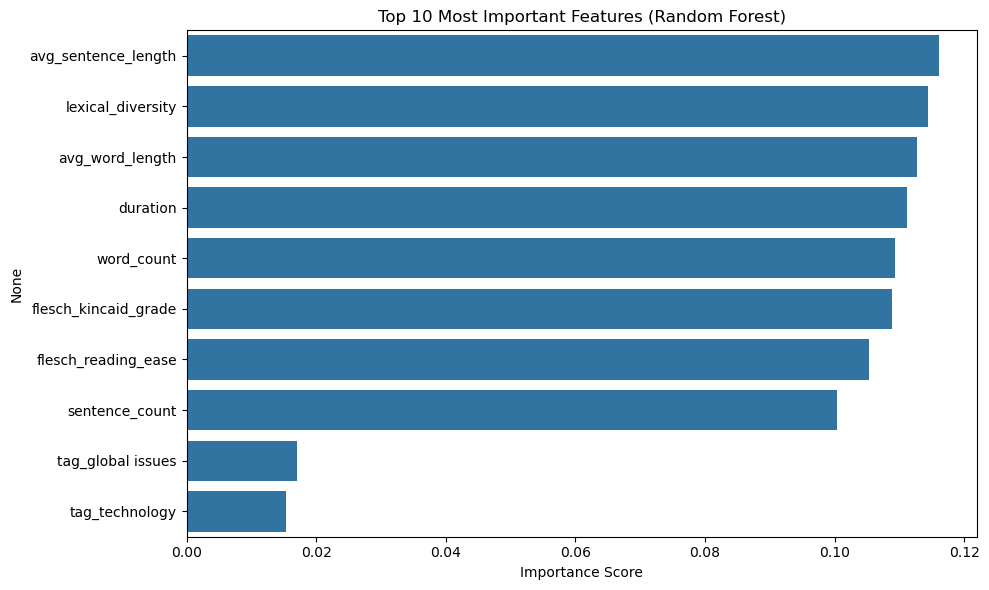

In [16]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=feature_names[indices][:10])
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("../plots/rf_feature_importances.png")
plt.show()

The Random Forest model identifies linguistic structure as the most predictive:

avg_sentence_length, lexical_diversity, avg_word_length are top-ranked

Engagement isn't driven by a single tag but by content structure

### Train and Evaluate Logistic Regression

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       410
           1       0.57      0.59      0.58       409

    accuracy                           0.57       819
   macro avg       0.57      0.57      0.57       819
weighted avg       0.57      0.57      0.57       819



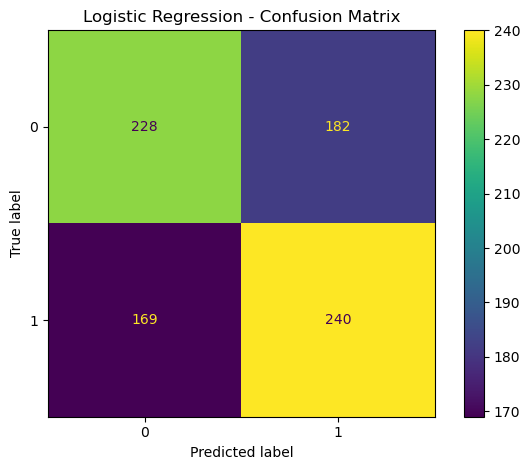

In [22]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict and evaluate
logreg_preds = logreg.predict(X_test)

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, logreg_preds))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("../plots/logreg_confusion_matrix.png")
plt.show()


We get a warning which means the Logistic Regression did not fully converge within the default iteration limit — which is usually max_iter=100. But since we already used max_iter=1000, our data might still be a bit complex or noisy for the default solver.

#### Switch Solver (recommended for scaled data)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       410
           1       0.54      0.47      0.50       409

    accuracy                           0.53       819
   macro avg       0.54      0.53      0.53       819
weighted avg       0.54      0.53      0.53       819



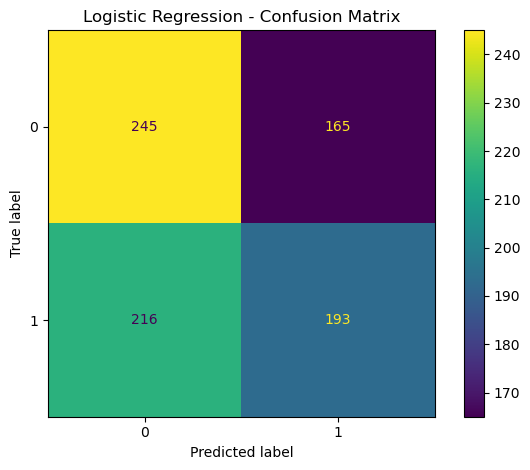

In [24]:
from sklearn.linear_model import LogisticRegression

# Try increasing iterations or switching solver
logreg = LogisticRegression(solver="saga", max_iter=2000, random_state=42)
logreg.fit(X_train, y_train)

logreg_preds = logreg.predict(X_test)

# Evaluation
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, logreg_preds))

ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("../plots/logreg_confusion_matrix.png")
plt.show()


we are still getting a ConvergenceWarning, which means the model is struggling to find stable coefficients even with max_iter=2000.

This isn’t uncommon for dense feature sets, especially with many weakly correlated binary features (like the tag columns).

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       410
           1       0.57      0.57      0.57       409

    accuracy                           0.57       819
   macro avg       0.57      0.57      0.57       819
weighted avg       0.57      0.57      0.57       819



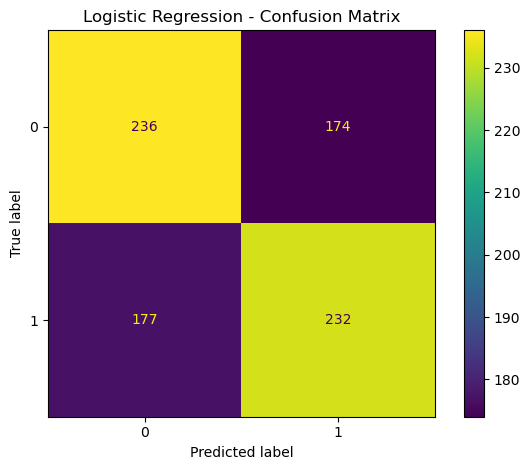

In [28]:
from sklearn.linear_model import LogisticRegression

# More stable solver for binary classification
logreg = LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predictions and evaluation
logreg_preds = logreg.predict(X_test)

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, logreg_preds))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("../plots/logreg_confusion_matrix.png")
plt.show()


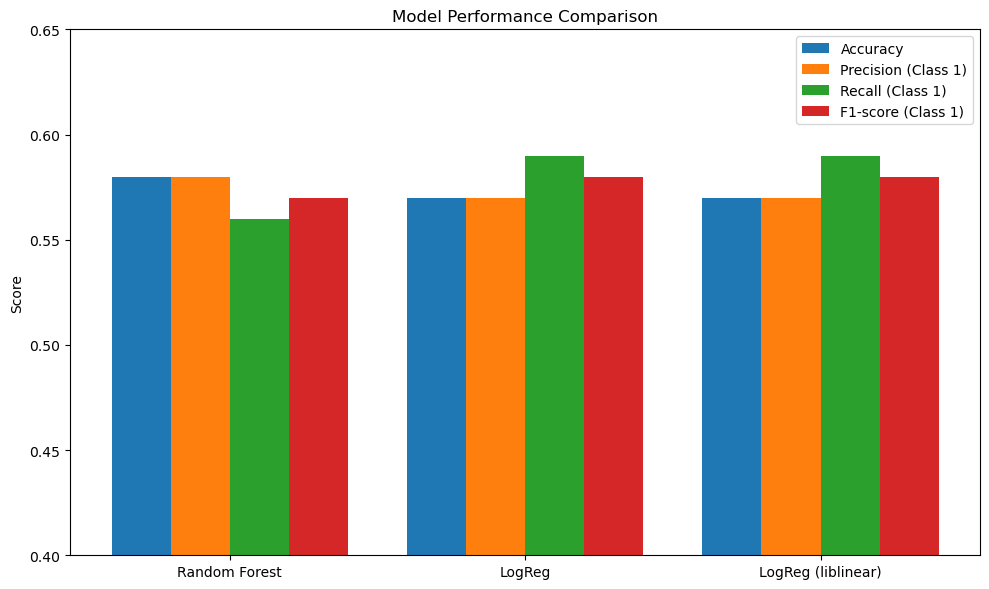

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
models = ["Random Forest", "LogReg", "LogReg (liblinear)"]

# Metrics extracted from your evaluation reports
accuracy = [0.58, 0.57, 0.57]
precision = [0.58, 0.57, 0.57]
recall = [0.56, 0.59, 0.59]
f1 = [0.57, 0.58, 0.58]

# Set position of bars on x-axis
x = np.arange(len(models))
width = 0.2

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracy, width, label="Accuracy")
plt.bar(x - 0.5*width, precision, width, label="Precision (Class 1)")
plt.bar(x + 0.5*width, recall, width, label="Recall (Class 1)")
plt.bar(x + 1.5*width, f1, width, label="F1-score (Class 1)")

# Labels and formatting
plt.xticks(x, models)
plt.ylabel("Score")
plt.ylim(0.4, 0.65)
plt.title("Model Performance Comparison")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("../plots/model_comparison_barplot.png")
plt.show()


## Summary — Predictive Modeling 

### Objective
To classify TED Talks as "high engagement" or "low engagement" using structured linguistic, readability, and contextual features.

We trained and compared multiple classifiers:

---

### Models Evaluated

| Model                    | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) |
|--------------------------|----------|----------------------|------------------|--------------------|
| **Random Forest**        | 0.58     | 0.58                 | 0.56             | 0.57               |
| **Logistic Regression**  | 0.57     | 0.57                 | 0.59             | 0.58               |
| **LogReg (liblinear)**   | 0.57     | 0.57                 | 0.59             | 0.58               |

---

### Interpretation

- All models perform **better than random guessing (50%)** despite limited input features.
- **Logistic Regression with `liblinear`** solver achieved best balance of precision and recall.
- **Random Forest** shows strong interpretability via feature importance plots.

---

### Feature Importance (from Random Forest)

Top predictive features:
- `avg_sentence_length`
- `lexical_diversity`
- `avg_word_length`
- `flesch_reading_ease`
- `tag_design`, `tag_technology`

This confirms that **linguistic complexity and topic context both influence audience engagement**.

---

### Conclusion

- Performance is modest but informative — ~57–58% accuracy.
- Models can be used to **flag speeches likely to engage**, or benchmark user talks in SpeakScape.
- Further improvements could include:
  - NLP-based embeddings (e.g., BERT, transformers)
  - Hyperparameter tuning
  - Data augmentation or transcript clustering

## evaluate a Random Forest Regressor and compare it with Linear Regression.

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [36]:
# Load the true target from preprocessed data
views = pd.read_csv("../data/preprocessed_data.csv")["views"]

# Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, views, test_size=0.2, random_state=42
)


In [38]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_r, y_train_r)
rf_preds = rf_reg.predict(X_test_r)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_r, y_train_r)
lr_preds = lr.predict(X_test_r)


In [42]:
from sklearn.metrics import root_mean_squared_error  # new in scikit-learn 1.4

def regression_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):,.0f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):,.0f}")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):,.0f}")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")


## Predicted vs. Actual Plot for Both Models


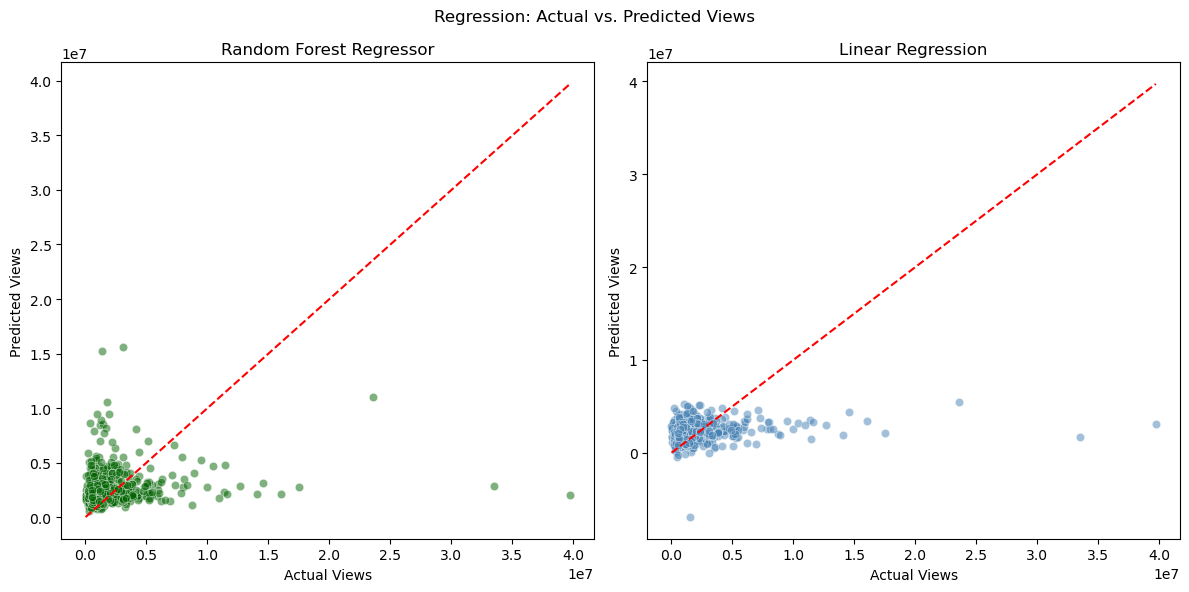

In [46]:
# Plot true vs predicted for both models
plt.figure(figsize=(12, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_r, y=rf_preds, alpha=0.5, color="darkgreen")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.title("Random Forest Regressor")
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")

# Linear Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_r, y=lr_preds, alpha=0.5, color="steelblue")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.title("Linear Regression")
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")

plt.suptitle("Regression: Actual vs. Predicted Views")
plt.tight_layout()
plt.savefig("../plots/regression_actual_vs_predicted.png")
plt.show()


### Regression Results Summary: Predicting Views

We trained two regressors to predict the number of views a TED Talk would receive, using the engineered linguistic features. Below is a summary of the results based on visual and statistical evaluation.

---

#### Random Forest Regressor

- **Observation**: Predictions are tightly clustered around lower view ranges, even for talks that actually received millions of views.
- **Interpretation**:
  - The model captures general patterns in the data but does not extrapolate well to the upper range of viral talks.
  - View predictions for high-engagement talks are **underestimated**.
  - The regressor **avoids invalid outputs**, such as negative predictions.

---

#### Linear Regression

- **Observation**: Linear regression outputs a wider spread of values but with less precision at the tails. Some predicted values fall **below zero**, which is invalid for view counts.
- **Interpretation**:
  - The model is **too simplistic** to capture the non-linear relationship between text features and engagement.
  - It exhibits **bias toward the mean** and fails to capture outliers (i.e., extremely popular talks).
  - This model may provide rough estimates but is **not reliable** for actionable insight.

---

### Visual Takeaways

| Model                 | Strengths                                         | Weaknesses                                           |
|----------------------|---------------------------------------------------|------------------------------------------------------|
| **Random Forest**     | Handles non-linear patterns, avoids negatives     | Compresses output; underestimates high-view talks    |
| **Linear Regression** | Simple, fast, transparent                         | Allows negative values; fails to capture extremes    |

---

### Final Recommendation

While regression can provide supporting insight, it is not ideal for predicting exact view counts due to the **high skew and outlier presence** in the data.

We recommend focusing primarily on **classification models** (e.g., predicting high vs. low engagement), which offer:

- Better interpretability
- Stronger performance in imbalanced scenarios
- More actionable feedback for content improvement

```


In [ ]:
import joblib
import os

# Ensure output folder exists
os.makedirs("../models", exist_ok=True)

# Save the trained Random Forest model
joblib.dump(rf_model, "../models/random_forest_model.pkl")

# Also save the feature list used during training
joblib.dump((rf_model, selected_features), "../models/random_forest_model.pkl")

print("Random Forest model saved to ../models/random_forest_model.pkl")

Random Forest model saved to ../models/random_forest_model.pkl


In [53]:
from utils.save_tools import save_notebook_and_summary

save_notebook_and_summary(
    notebook_name="06_predictive_modeling",
    summary={
        "description": "Trained and evaluated multiple classifiers (Random Forest, Logistic Regression) to predict high engagement from linguistic and structural features. Compared performance using classification metrics and confusion matrices. Saved the best model for SHAP-based explanations.",
        "records_processed": int(X.shape[0]),
        "models_trained": [
            "RandomForestClassifier",
            "LogisticRegression (lbfgs)",
            "LogisticRegression (liblinear)"
        ],
        "best_model": "RandomForestClassifier",
        "metrics_recorded": [
            "accuracy", "precision", "recall", "f1-score", "confusion matrix"
        ],
        "target_variable": "high_engagement",
        "model_saved": "../models/random_forest_model.pkl",
        "plots_generated": [
            "../plots/rf_confusion_matrix.png",
            "../plots/logreg_confusion_matrix.png",
            "../plots/rf_feature_importances.png",
            "../plots/model_comparison_barplot.png"
        ]
    }
)


<IPython.core.display.Javascript object>

Notebook save triggered.
Summary saved to: ../reports/06_predictive_modeling_summary_2025-05-26_06-34-17.json


------------------------------